# Laboratorium 1

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
          
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points


class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)


class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    

    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

___

# Rozwiązanie
## Zbiór punktów nr.1

<IPython.core.display.Javascript object>


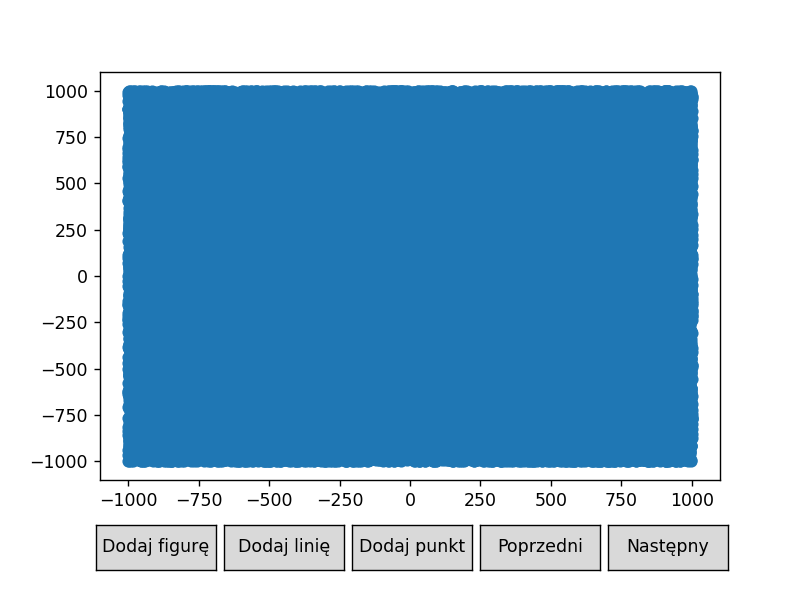

In [3]:
%matplotlib notebook

x = np.random.uniform(-1000, 1000, 10**5)
y = np.random.uniform(-1000, 1000, 10**5)

data_set_1 = np.dstack((x, y))[0]

plot = Plot(points=[PointsCollection(data_set_1)])
plot.draw()

## Zbiór punktów nr.2

<IPython.core.display.Javascript object>


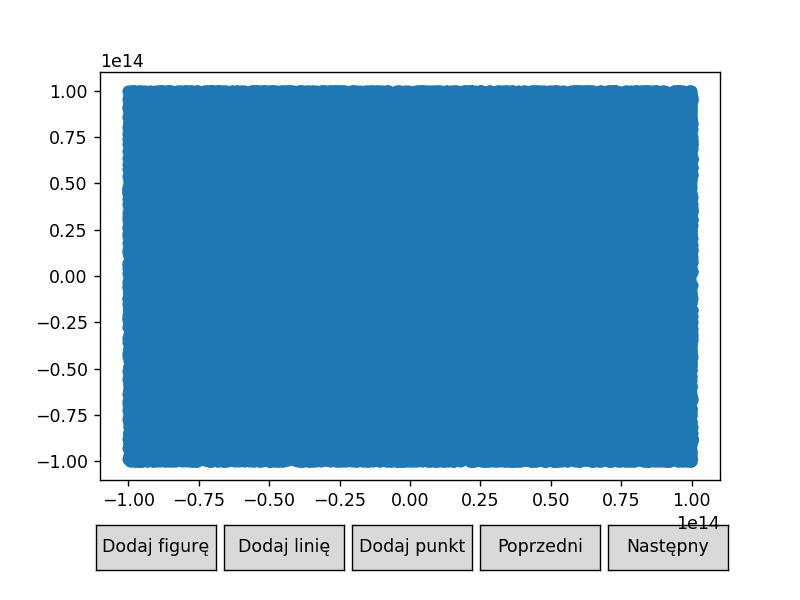

In [4]:
x = np.random.uniform(-10**14, 10**14, 10**5)
y = np.random.uniform(-10**14, 10**14, 10**5)

data_set_2 = np.dstack((x, y))[0]

plot = Plot(points=[PointsCollection(data_set_2)])
plot.draw()

## Zbiór punktów nr.3

<IPython.core.display.Javascript object>


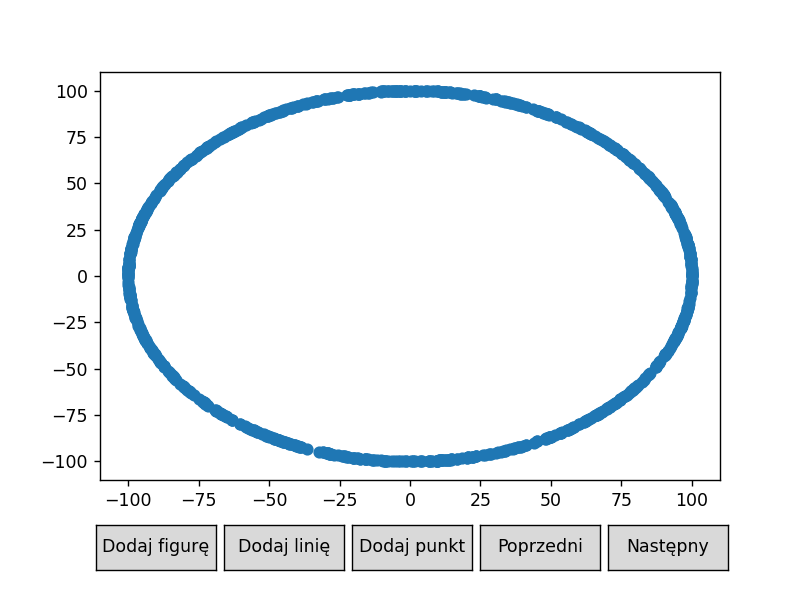

In [5]:
r = 100
t = np.random.uniform(0, 2*np.pi, 1000)

x = r*np.cos(t) 
y = r*np.sin(t) 

data_set_3 = np.dstack((x, y))[0]

plot = Plot(points=[PointsCollection(data_set_3)])
plot.draw()

## Zbiór punktów nr.4

<IPython.core.display.Javascript object>


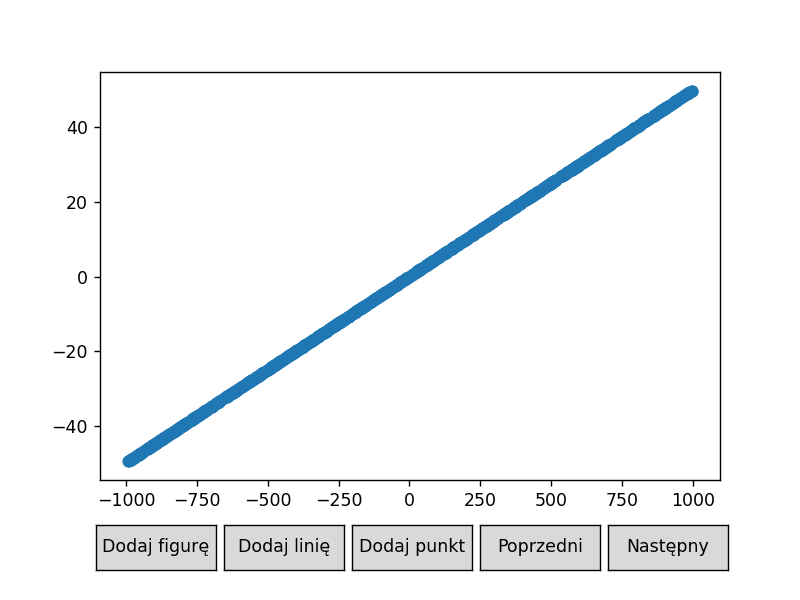

In [6]:
pt_a = (-1, 0)
pt_b = (1, 0.1)

a = (pt_b[1] - pt_a[1])/(pt_b[0] - pt_a[0])
b = pt_a[1] - pt_a[0]*a

x = np.random.uniform(-1000, 1000, 1000)
fun = lambda x: a*x + b
y = fun(x)

data_set_4 = np.dstack((x, y))[0]

plot = Plot(points=[PointsCollection(data_set_4)])
plot.draw()

___

## Funkcje liczące wyznaczniki macierzy 2x2 i 3x3

In [7]:
def det_2x2(mat):
    return mat[0, 0]*mat[1, 1] - mat[0, 1]*mat[1, 0]

def det_3x3(mat):
    return (mat[0, 0]*mat[1, 1]*mat[2, 2] + mat[1, 0]*mat[2, 1]*mat[0, 2] + mat[2, 0]*mat[0, 1]*mat[1, 2] - 
            mat[2, 0]*mat[1, 1]*mat[0, 2] - mat[1, 0]*mat[0, 1]*mat[2, 2] - mat[0, 0]*mat[2, 1]*mat[1, 2])


In [8]:
det_functions = [det_2x2, np.linalg.det, det_3x3, np.linalg.det]

## Podział punktów względem orientacji w stosunku do odcinka AB

In [9]:
def classification(data_set, tolerance=0, vect=((-1, 0), (1, 0.1))):
    result = [{
        "left": [],
        "center": [],
        "right": [],
        } for _ in range(len(det_functions))]
    
    for pt in data_set:
        mat_2x2 = np.array([[vect[0][0] - pt[0], vect[0][1] - pt[1]],
                            [vect[1][0] - pt[0], vect[1][1] - pt[1]]])
        mat_3x3 = np.array([[vect[0][0], vect[0][1], 1],
                            [vect[1][0], vect[1][1], 1],
                            [pt[0],      pt[1],      1]])
        
        for i in range(len(det_functions)):
            if i < 2:
                d = det_functions[i](mat_2x2)
            else:
                d = det_functions[i](mat_3x3)
            
            if d > tolerance:
                result[i]["left"].append(pt)
            elif d < -tolerance:
                result[i]["right"].append(pt)
            else:
                result[i]["center"].append(pt)
        
    return result

In [85]:
def print_classified(result_data, det_nr):
    plot = Plot(points=[PointsCollection(result_data[det_nr]["left"], color="blueviolet"),
                        PointsCollection(result_data[det_nr]["center"], color="red"),
                        PointsCollection(result_data[det_nr]["right"], color="gold")])
    plot.draw()
    
    print(f'Left: {len(result_data[det_nr]["left"])}')
    print(f'Center: {len(result_data[det_nr]["center"])}')
    print(f'Right: {len(result_data[det_nr]["right"])}')

___

## Klasyfikacja dla zbioru punktów nr.1

In [56]:
result_1_tol0 = classification(data_set_1, tolerance=10e-18)

- Zaimplementowana funkcja dla wyznacznika 2x2

<IPython.core.display.Javascript object>


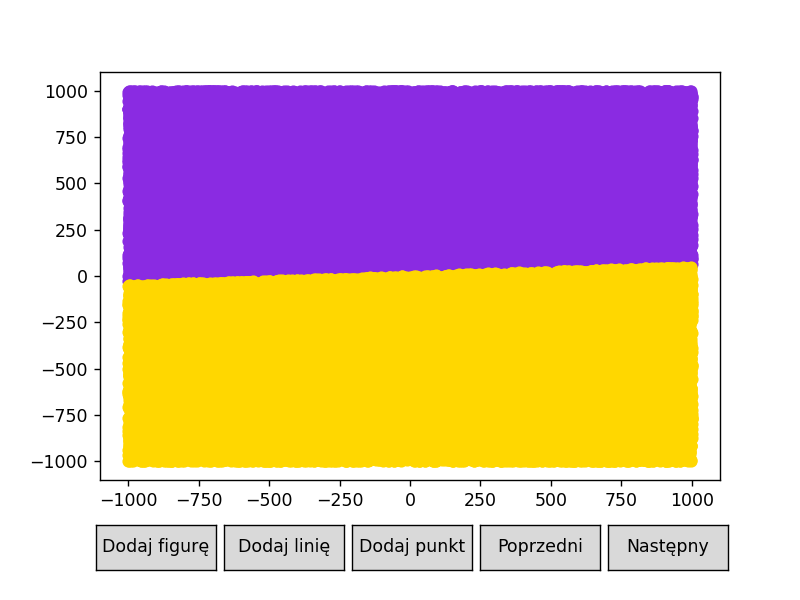

Left: 49920
Center: 0
Right: 50080


In [57]:
print_classified(result_1_tol0, 0)

---

- Funkcja z biblioteki Numpy dla wyznacznika 2x2

<IPython.core.display.Javascript object>


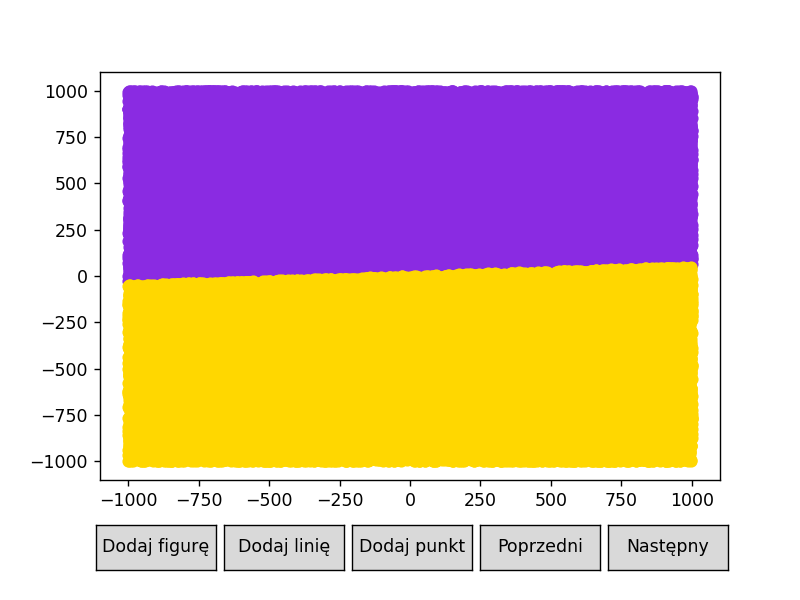

Left: 49920
Center: 0
Right: 50080


In [58]:
print_classified(result_1_tol0, 1)

---

- Zaimplementowana funkcja dla wyznacznika 3x3

<IPython.core.display.Javascript object>


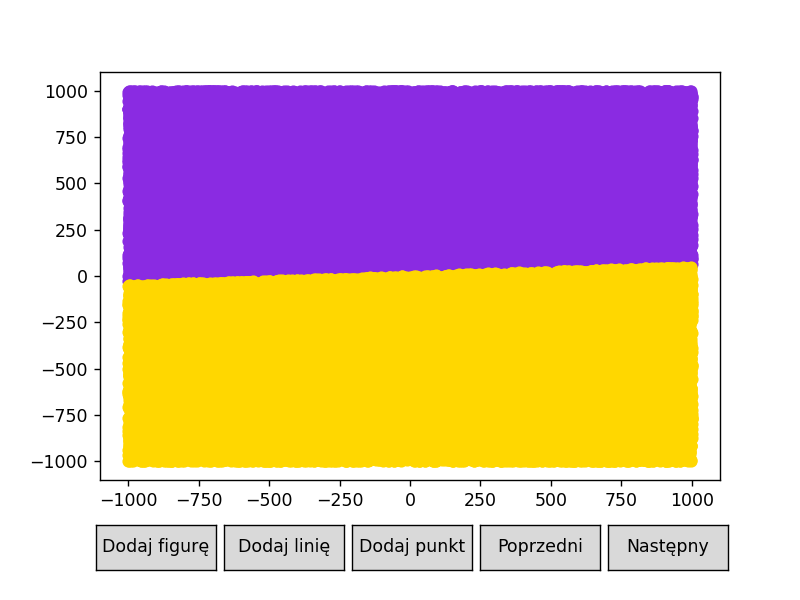

Left: 49920
Center: 0
Right: 50080


In [59]:
print_classified(result_1_tol0, 2)

---

- Funkcja z biblioteki Numpy dla wyznacznika 3x3

<IPython.core.display.Javascript object>


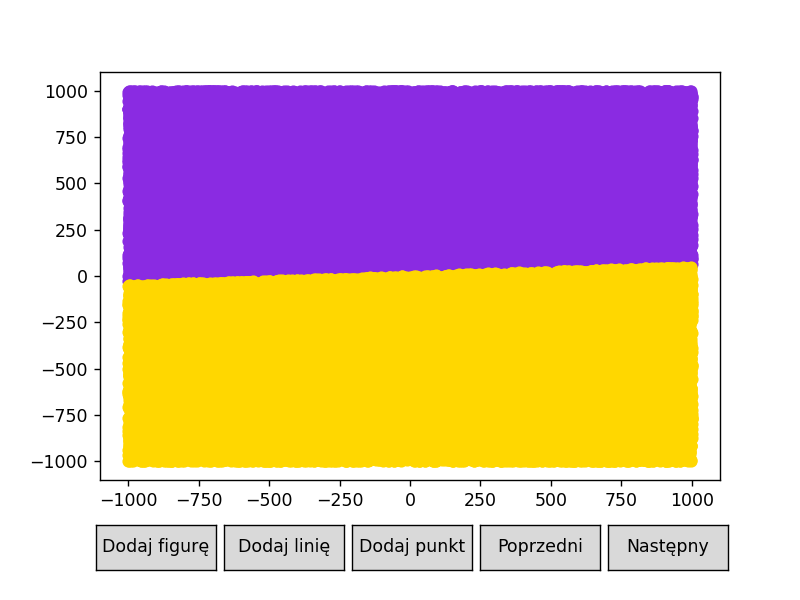

Left: 49920
Center: 0
Right: 50080


In [60]:
print_classified(result_1_tol0, 3)

___

## Klasyfikacja dla zbioru punktów nr.2

In [61]:
result_2_tol0 = classification(data_set_2, tolerance=10e-18)

- Zaimplementowana funkcja dla wyznacznika 2x2

<IPython.core.display.Javascript object>


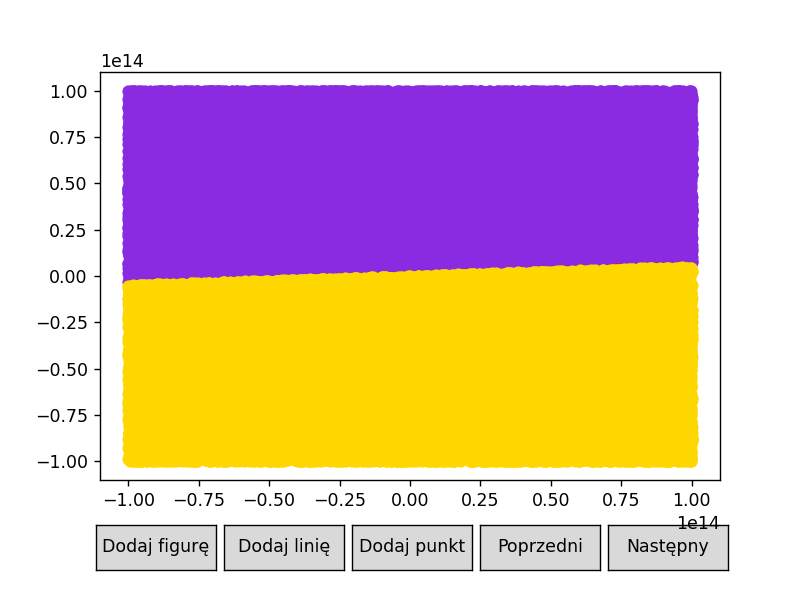

Left: 50144
Right: 49852
Center: 4


In [90]:
print_classified(result_2_tol0, 0)

___

- Funkcja z biblioteki Numpy dla wyznacznika 2x2

<IPython.core.display.Javascript object>


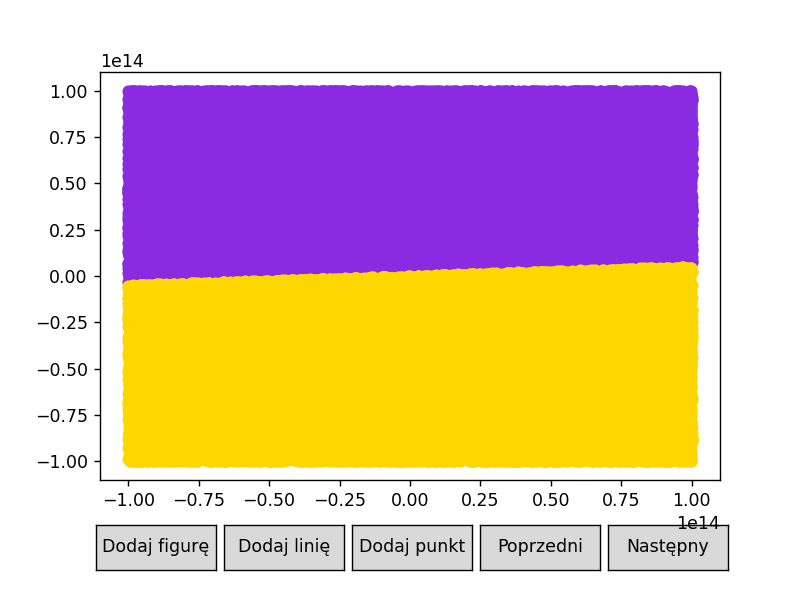

Left: 50144
Right: 49856
Center: 0


In [88]:
print_classified(result_2_tol0, 1)

___

- Zaimplementowana funkcja dla wyznacznika 3x3

<IPython.core.display.Javascript object>


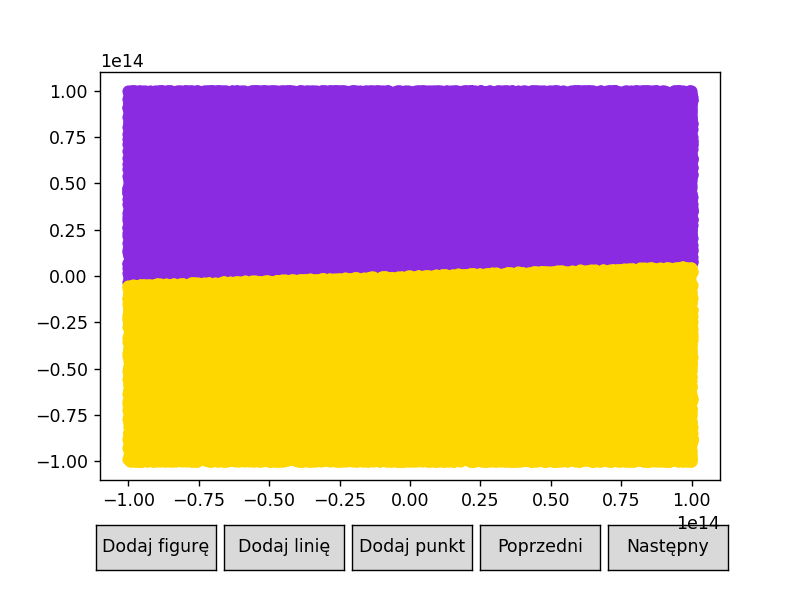

Left: 50145
Center: 0
Right: 49855


In [64]:
print_classified(result_2_tol0, 2)

___

- Funkcja z biblioteki Numpy dla wyznacznika 3x3

<IPython.core.display.Javascript object>


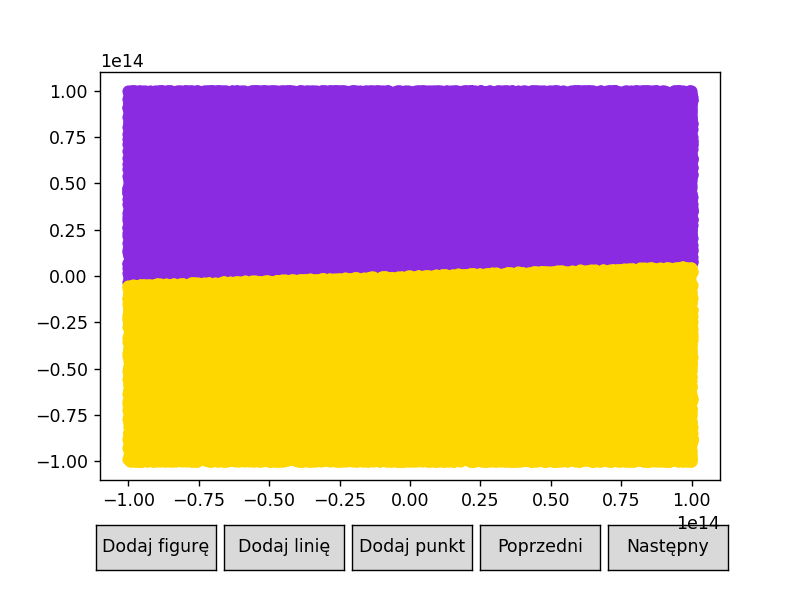

Left: 50145
Center: 0
Right: 49855


In [65]:
print_classified(result_2_tol0, 3)

___

## Klasyfikacja dla zbioru punktów nr.3

In [66]:
result_3_tol0 = classification(data_set_3, tolerance=10e-18)

- Zaimplementowana funkcja dla wyznacznika 2x2

<IPython.core.display.Javascript object>


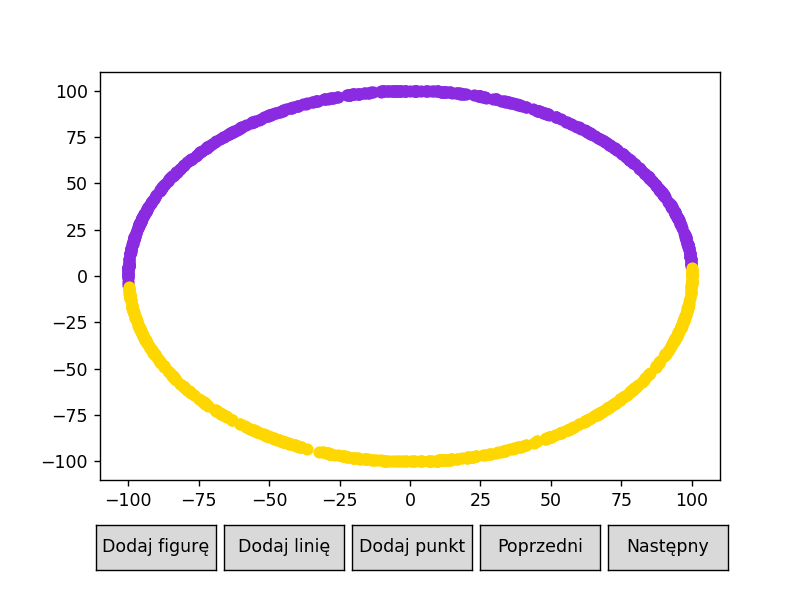

Left: 507
Center: 0
Right: 493


In [67]:
print_classified(result_3_tol0, 0)

___

- Funkcja z biblioteki Numpy dla wyznacznika 2x2

<IPython.core.display.Javascript object>


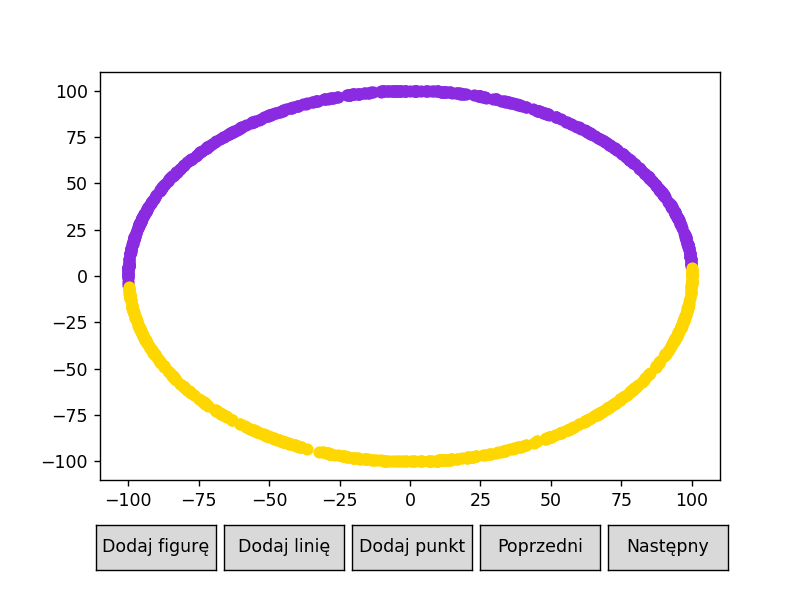

Left: 507
Center: 0
Right: 493


In [68]:
print_classified(result_3_tol0, 1)

___

- Zaimplementowana funkcja dla wyznacznika 3x3

<IPython.core.display.Javascript object>


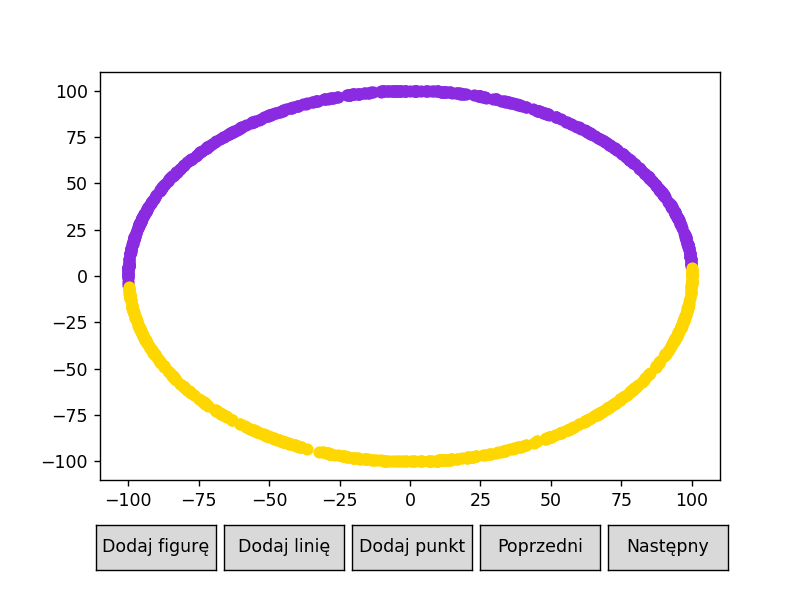

Left: 507
Center: 0
Right: 493


In [69]:
print_classified(result_3_tol0, 2)

___

- Funkcja z biblioteki Numpy dla wyznacznika 3x3

<IPython.core.display.Javascript object>


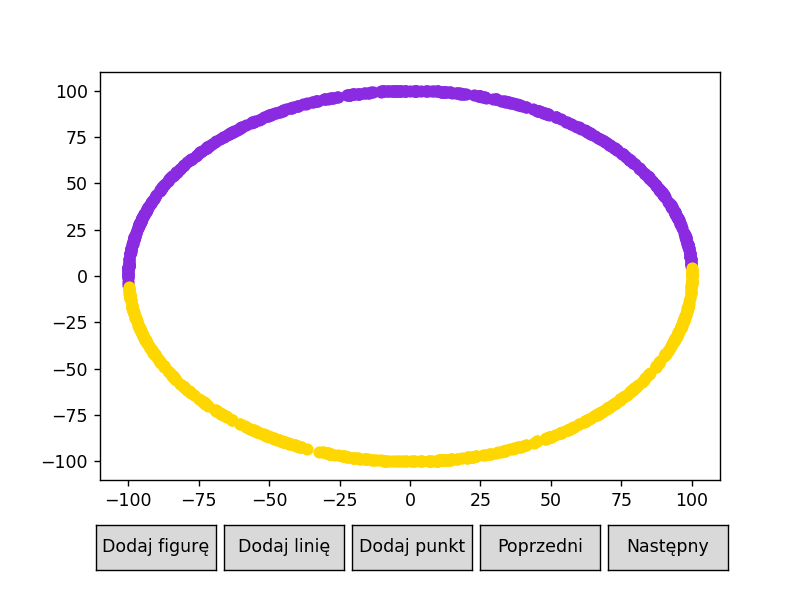

Left: 507
Center: 0
Right: 493


In [70]:
print_classified(result_3_tol0, 3)

___

## Klasyfikacja dla zbioru punktów nr.4

In [71]:
result_4_tol0 = classification(data_set_4, tolerance=10e-18)

- Zaimplementowana funkcja dla wyznacznika 2x2

<IPython.core.display.Javascript object>


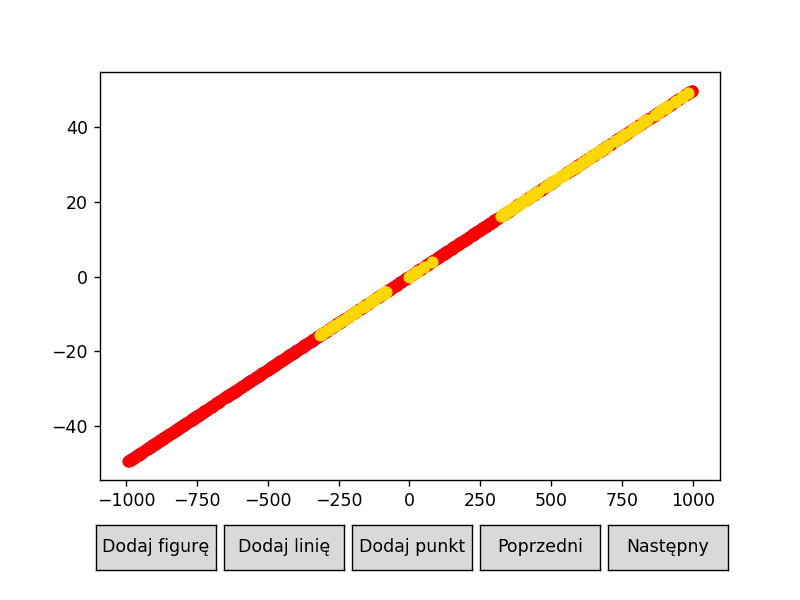

Left: 178
Center: 667
Right: 155


In [72]:
print_classified(result_4_tol0, 0)

___

- Funkcja z biblioteki Numpy dla wyznacznika 2x2

<IPython.core.display.Javascript object>


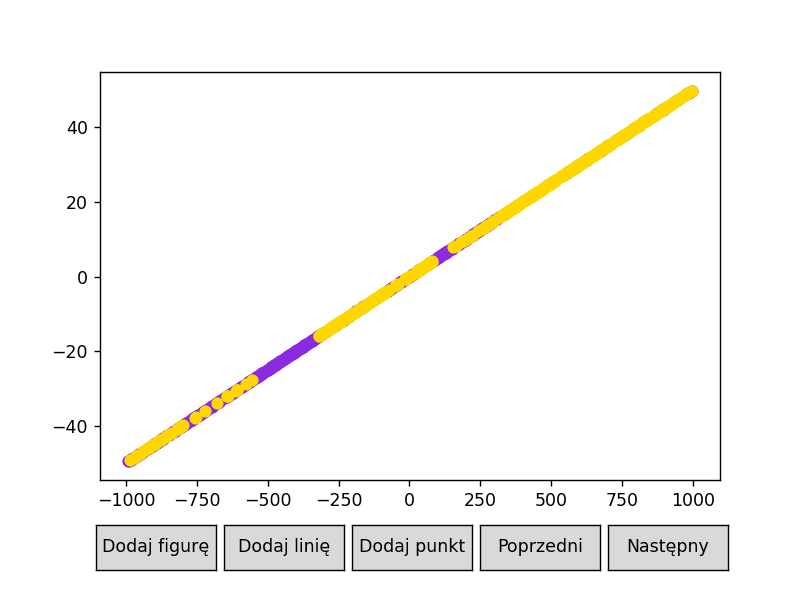

Left: 489
Center: 1
Right: 510


In [73]:
print_classified(result_4_tol0, 1)

___

- Zaimplementowana funkcja dla wyznacznika 3x3

<IPython.core.display.Javascript object>


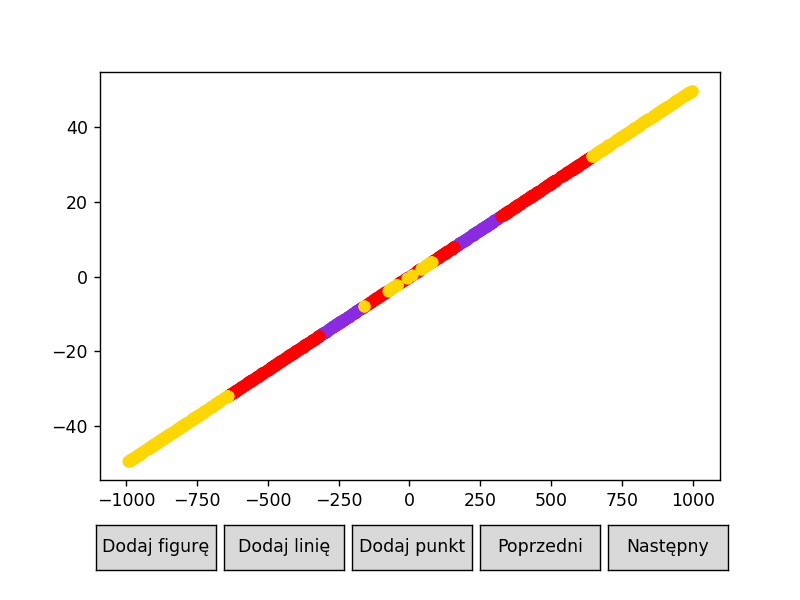

Left: 178
Center: 445
Right: 377


In [74]:
print_classified(result_4_tol0, 2)

___

- Funkcja z biblioteki Numpy dla wyznacznika 3x3

<IPython.core.display.Javascript object>


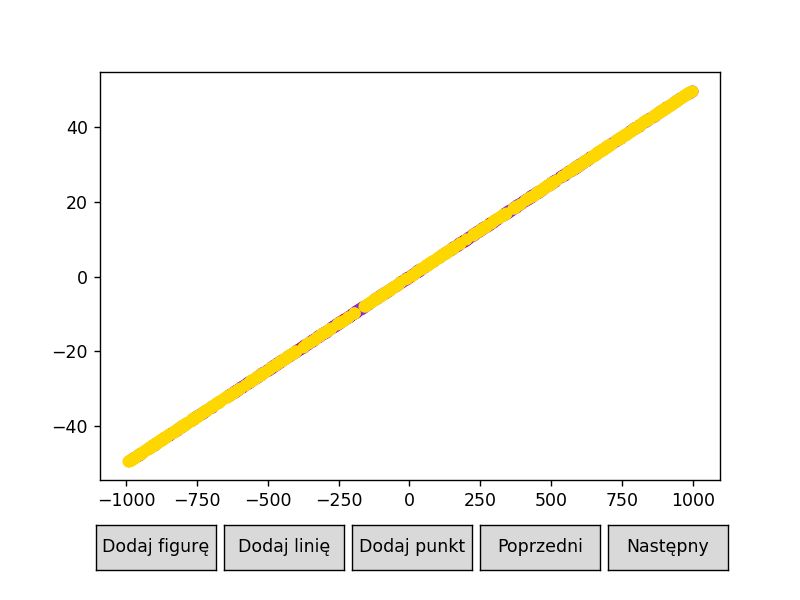

Left: 489
Center: 9
Right: 502


In [75]:
print_classified(result_4_tol0, 3)

___

## Porównanie wyników

In [76]:
def compare_results(data_set, det1, det2):
    differences = []

    res_det1 = [(v, key) for key, val in data_set[det1].items() for v in val]
    res_det1.sort(key=lambda x: x[0][0])
    
    res_det2 = [(v, key) for key, val in data_set[det2].items() for v in val]
    res_det2.sort(key=lambda x: x[0][0])
    
    for i in range(len(res_det1)):
        if res_det1[i][1] != res_det2[i][1]:
            differences.append(res_det1[i][0])
            
    return differences

In [77]:
def print_differences(data_set, det1, det2):
    differences = compare_results(data_set, det1, det2)
    plot = Plot(points=[PointsCollection(differences)])
    plot.draw()
    print(f"Number of differences: {len(differences)}")

___

## Wizualizacja różnic

- Zbiór punktów nr.2 (zaimplementowana funkcja 2x2 oraz funkcja z biblioteki Numpy 2x2)

<IPython.core.display.Javascript object>


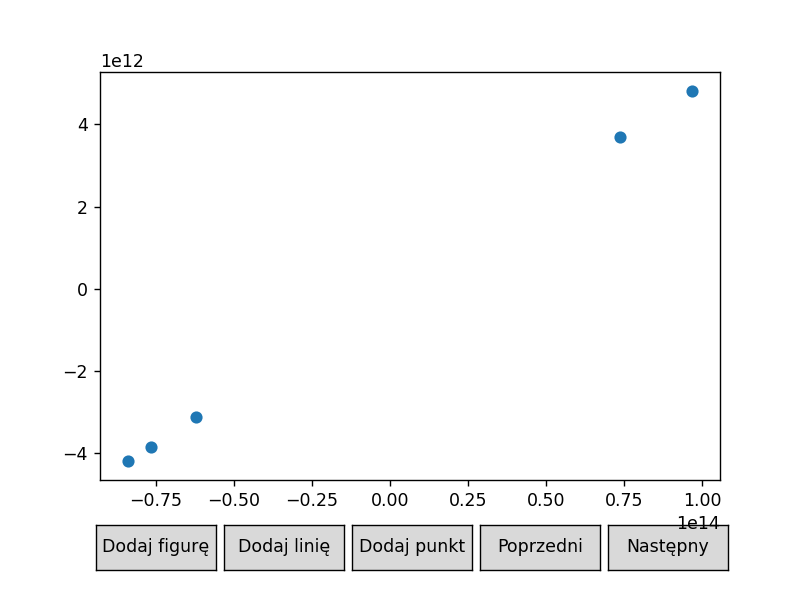

Number of differences: 5


In [78]:
print_differences(result_2_tol0, 0, 1)

___

- Zbiór punktów nr.2 (zaimplementowana funkcja 2x2 oraz zaimplementowana funkcja 3x3)

<IPython.core.display.Javascript object>


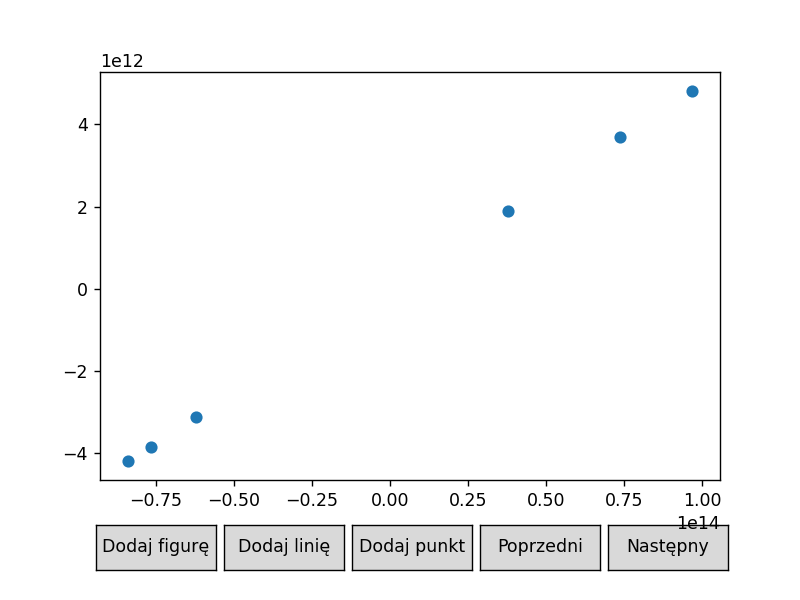

Number of differences: 6


In [79]:
print_differences(result_2_tol0, 0, 2)

___

- Zbiór punktów nr.2 (funkcja z biblioteki Numpy 2x2 oraz funkcja z biblioteki Numpy 3x3)

<IPython.core.display.Javascript object>


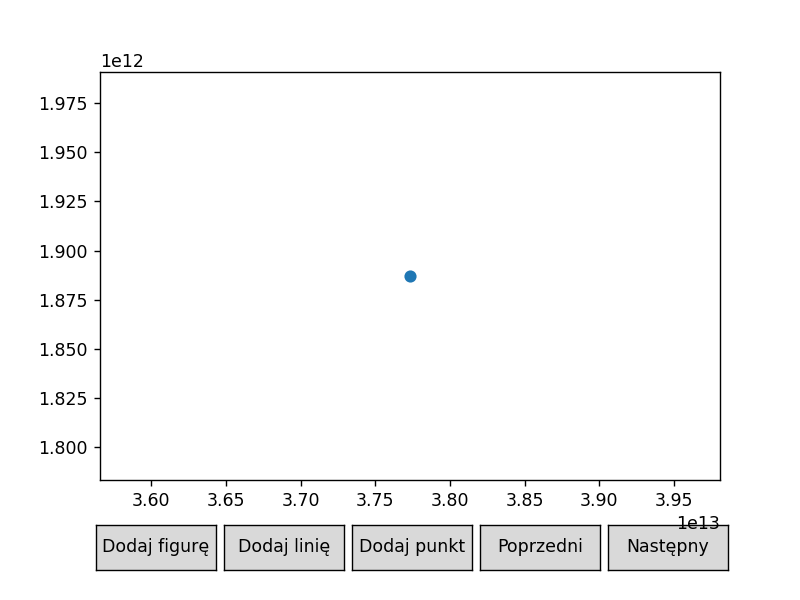

Number of differences: 1


In [80]:
print_differences(result_2_tol0, 1, 3)

___

- Zbiór punktów nr.4 (zaimplementowana funkcja 2x2 oraz funkcja z biblioteki Numpy 2x2)

<IPython.core.display.Javascript object>


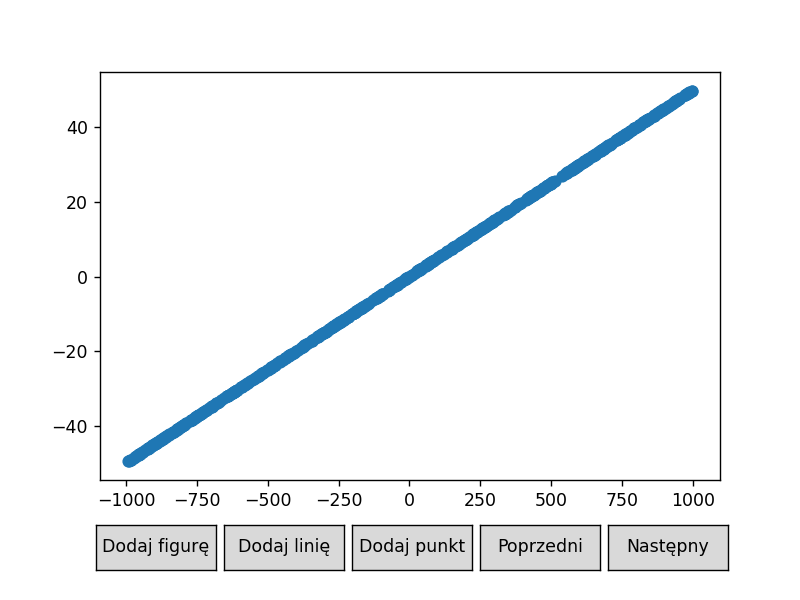

Number of differences: 699


In [81]:
print_differences(result_4_tol0, 0, 1)

___

- Zbiór punktów nr.4 (zaimplementowana funkcja 2x2 oraz zaimplementowana funkcja 3x3)

<IPython.core.display.Javascript object>


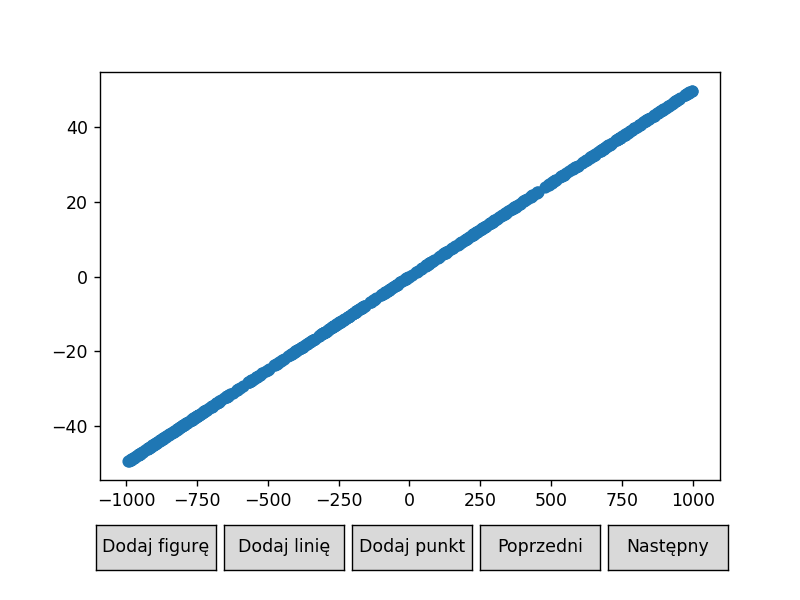

Number of differences: 665


In [82]:
print_differences(result_4_tol0, 0, 2)

___

- Zbiór punktów nr.4 (zaimplementowana funkcja 3x3 oraz funkcja z biblioteki Numpy 3x3)

<IPython.core.display.Javascript object>


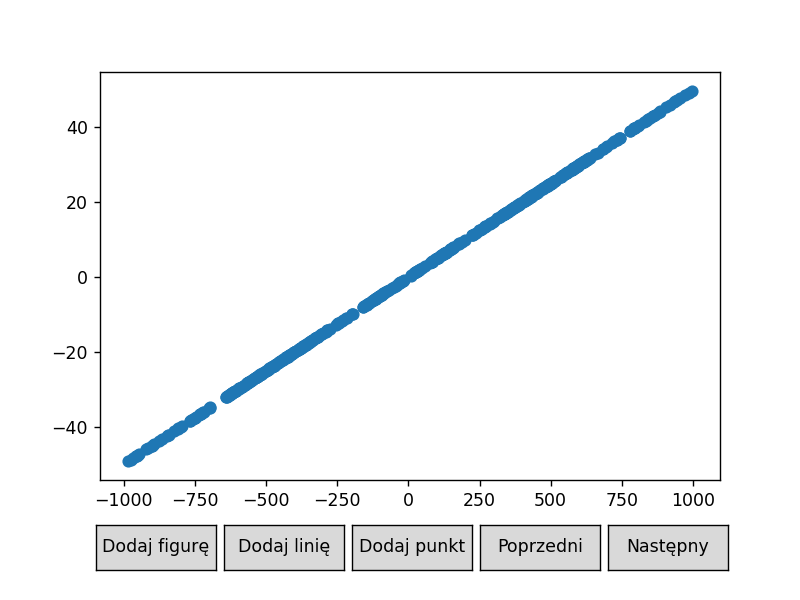

Number of differences: 590


In [83]:
print_differences(result_4_tol0, 2, 3)

___

- Zbiór punktów nr.4 (funkcja z biblioteki Numpy 2x2 oraz funkcja z biblioteki Numpy 3x3)

<IPython.core.display.Javascript object>


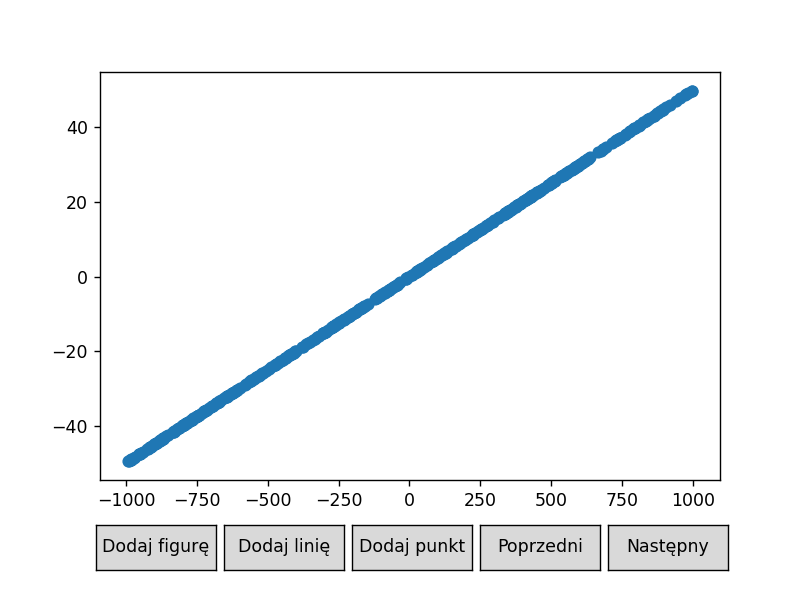

Number of differences: 498


In [84]:
print_differences(result_4_tol0, 1, 3)

___

## Porównanie wyników dla różnych tolerancji

In [50]:
tolerances = [10e-18, 10e-15, 10e-12, 10e-9]

In [51]:
def print_diff_tolerances(data_set, tolerances):
    det_names=["Implemented function for 2x2 det",
               "Numpy function for 2x2 det",
               "Implemented function for 3x3 det",
               "Numpy function for 3x3 det",]
    scenes = []
    
    for tol in tolerances:
        result_classified = classification(data_set, tol)
        print(f"Tolerance {tol}:")
        print("----------------")  
        
        for det_nr in range(len(result_classified)):
            scenes.append(Scene([PointsCollection(result_classified[det_nr]["left"], color="blueviolet", marker = "^"),
                                 PointsCollection(result_classified[det_nr]["right"], color="gold"),
                                 PointsCollection(result_classified[det_nr]["center"], color="red", marker = "1")]))
            
            print(det_names[det_nr])
            print(f'\t Left: {len(result_classified[det_nr]["left"])} \t Center: {len(result_classified[det_nr]["center"])} \t Right: {len(result_classified[det_nr]["right"])}\n')
        print("----------------\n\n") 
        
    return scenes

___

- Zbiór punktów nr.1

In [52]:
scenes_data1 = print_diff_tolerances(data_set_1, tolerances)

Tolerance 1e-17:
----------------
Implemented function for 2x2 det
	 Left: 49920 	 Center: 0 	 Right: 50080

Numpy function for 2x2 det
	 Left: 49920 	 Center: 0 	 Right: 50080

Implemented function for 3x3 det
	 Left: 49920 	 Center: 0 	 Right: 50080

Numpy function for 3x3 det
	 Left: 49920 	 Center: 0 	 Right: 50080

----------------


Tolerance 1e-14:
----------------
Implemented function for 2x2 det
	 Left: 49920 	 Center: 0 	 Right: 50080

Numpy function for 2x2 det
	 Left: 49920 	 Center: 0 	 Right: 50080

Implemented function for 3x3 det
	 Left: 49920 	 Center: 0 	 Right: 50080

Numpy function for 3x3 det
	 Left: 49920 	 Center: 0 	 Right: 50080

----------------


Tolerance 1e-11:
----------------
Implemented function for 2x2 det
	 Left: 49920 	 Center: 0 	 Right: 50080

Numpy function for 2x2 det
	 Left: 49920 	 Center: 0 	 Right: 50080

Implemented function for 3x3 det
	 Left: 49920 	 Center: 0 	 Right: 50080

Numpy function for 3x3 det
	 Left: 49920 	 Center: 0 	 Right: 500

<IPython.core.display.Javascript object>


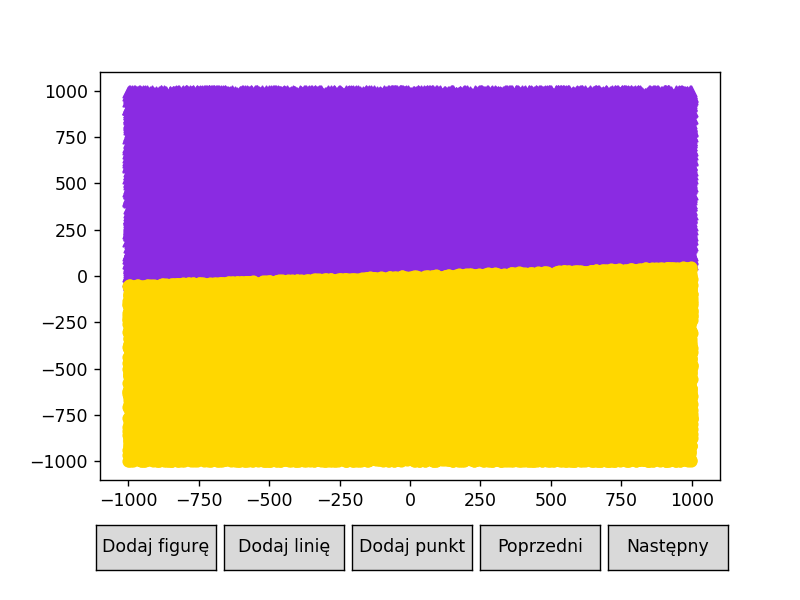

In [43]:
plot_data1 = Plot(scenes=scenes_data1)
plot_data1.draw()

___

- Zbiór punktów nr.2

In [44]:
scenes_data2 = print_diff_tolerances(data_set_2, tolerances)

Tolerance 1e-14:
----------------
Implemented function for 2x2 det
	 Left: 50144 	 Center: 4 	 Right: 49852

Numpy function for 2x2 det
	 Left: 50144 	 Center: 0 	 Right: 49856

Implemented function for 3x3 det
	 Left: 50145 	 Center: 0 	 Right: 49855

Numpy function for 3x3 det
	 Left: 50145 	 Center: 0 	 Right: 49855

----------------


Tolerance 1e-11:
----------------
Implemented function for 2x2 det
	 Left: 50144 	 Center: 4 	 Right: 49852

Numpy function for 2x2 det
	 Left: 50144 	 Center: 0 	 Right: 49856

Implemented function for 3x3 det
	 Left: 50145 	 Center: 0 	 Right: 49855

Numpy function for 3x3 det
	 Left: 50145 	 Center: 0 	 Right: 49855

----------------


Tolerance 1e-08:
----------------
Implemented function for 2x2 det
	 Left: 50144 	 Center: 4 	 Right: 49852

Numpy function for 2x2 det
	 Left: 50144 	 Center: 0 	 Right: 49856

Implemented function for 3x3 det
	 Left: 50145 	 Center: 0 	 Right: 49855

Numpy function for 3x3 det
	 Left: 50145 	 Center: 0 	 Right: 498

<IPython.core.display.Javascript object>


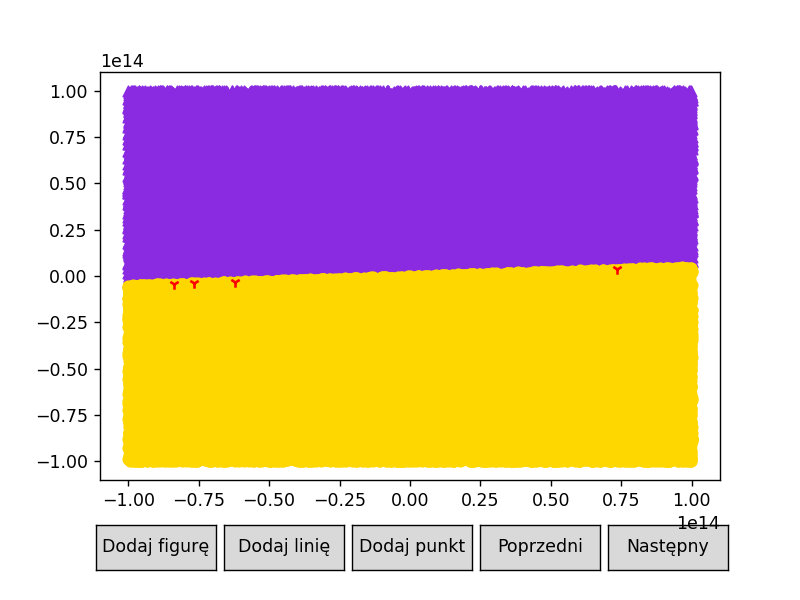

In [45]:
plot_data2 = Plot(scenes=scenes_data2)
plot_data2.draw()

___

- Zbiór punktów nr.3

In [46]:
scenes_data3 = print_diff_tolerances(data_set_3, tolerances)

Tolerance 1e-14:
----------------
Implemented function for 2x2 det
	 Left: 507 	 Center: 0 	 Right: 493

Numpy function for 2x2 det
	 Left: 507 	 Center: 0 	 Right: 493

Implemented function for 3x3 det
	 Left: 507 	 Center: 0 	 Right: 493

Numpy function for 3x3 det
	 Left: 507 	 Center: 0 	 Right: 493

----------------


Tolerance 1e-11:
----------------
Implemented function for 2x2 det
	 Left: 507 	 Center: 0 	 Right: 493

Numpy function for 2x2 det
	 Left: 507 	 Center: 0 	 Right: 493

Implemented function for 3x3 det
	 Left: 507 	 Center: 0 	 Right: 493

Numpy function for 3x3 det
	 Left: 507 	 Center: 0 	 Right: 493

----------------


Tolerance 1e-08:
----------------
Implemented function for 2x2 det
	 Left: 507 	 Center: 0 	 Right: 493

Numpy function for 2x2 det
	 Left: 507 	 Center: 0 	 Right: 493

Implemented function for 3x3 det
	 Left: 507 	 Center: 0 	 Right: 493

Numpy function for 3x3 det
	 Left: 507 	 Center: 0 	 Right: 493

----------------


Tolerance 1e-05:
--------

<IPython.core.display.Javascript object>


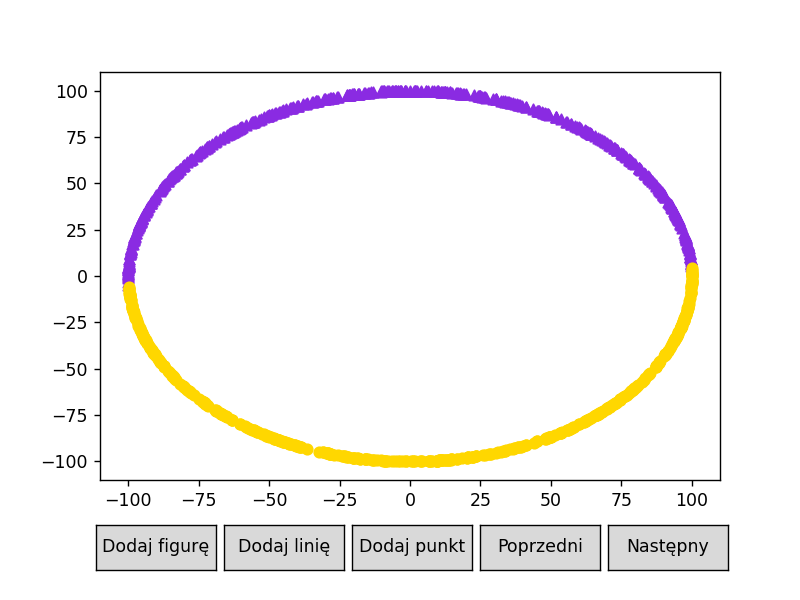

In [47]:
plot_data3 = Plot(scenes=scenes_data3)
plot_data3.draw()

___

- Zbiór punktów nr.4

In [48]:
scenes_data4 = print_diff_tolerances(data_set_4, tolerances)

Tolerance 1e-14:
----------------
Implemented function for 2x2 det
	 Left: 172 	 Center: 678 	 Right: 150

Numpy function for 2x2 det
	 Left: 448 	 Center: 89 	 Right: 463

Implemented function for 3x3 det
	 Left: 0 	 Center: 1000 	 Right: 0

Numpy function for 3x3 det
	 Left: 11 	 Center: 895 	 Right: 94

----------------


Tolerance 1e-11:
----------------
Implemented function for 2x2 det
	 Left: 0 	 Center: 1000 	 Right: 0

Numpy function for 2x2 det
	 Left: 0 	 Center: 1000 	 Right: 0

Implemented function for 3x3 det
	 Left: 0 	 Center: 1000 	 Right: 0

Numpy function for 3x3 det
	 Left: 0 	 Center: 1000 	 Right: 0

----------------


Tolerance 1e-08:
----------------
Implemented function for 2x2 det
	 Left: 0 	 Center: 1000 	 Right: 0

Numpy function for 2x2 det
	 Left: 0 	 Center: 1000 	 Right: 0

Implemented function for 3x3 det
	 Left: 0 	 Center: 1000 	 Right: 0

Numpy function for 3x3 det
	 Left: 0 	 Center: 1000 	 Right: 0

----------------


Tolerance 1e-05:
--------------

<IPython.core.display.Javascript object>


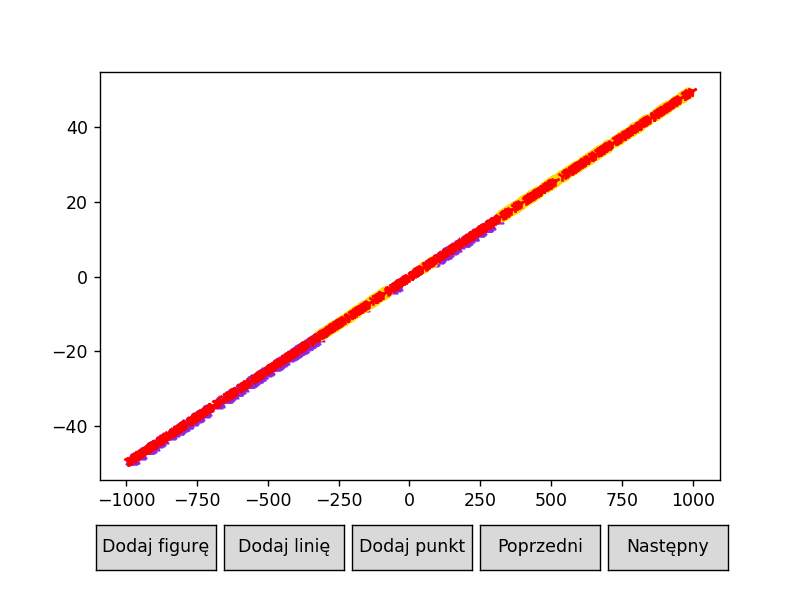

In [49]:
plot_data4 = Plot(scenes=scenes_data4)
plot_data4.draw()